In [9]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [22]:
#生成数据集
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [23]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.2346, 0.5740]) 
label: tensor([2.7121])


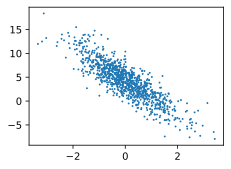

In [12]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

In [24]:
# 读取数据集
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    # 创建每个样本的索引
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    # 打乱索引
    random.shuffle(indices)
    # 遍历0到num_examples，每次步长为batch_size
    for i in range(0, num_examples, batch_size):
        # 一次取i到min(i + batch_size, num_examples)个样本
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        # 返回该批次的特征和标签
        yield features[batch_indices], labels[batch_indices]
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[-5.1826e-01,  1.3188e+00],
        [ 3.2377e-01, -1.3540e+00],
        [-2.4787e-01,  1.0696e+00],
        [ 5.5751e-01,  6.9435e-01],
        [ 1.1223e+00,  1.1889e+00],
        [-2.7072e-01, -3.5435e-01],
        [-4.1602e-01,  1.3385e+00],
        [ 3.4413e-01,  5.0557e-01],
        [ 1.8441e-01, -1.0840e+00],
        [-9.8095e-01,  4.2243e-04]]) 
 tensor([[-1.3134],
        [ 9.4520],
        [ 0.0706],
        [ 2.9542],
        [ 2.4092],
        [ 4.8509],
        [-1.1864],
        [ 3.1449],
        [ 8.2465],
        [ 2.2392]])


In [14]:
# 从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重
# 将偏置初始化为0

w = torch.normal(0, 0.01 ,size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [15]:

def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [16]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    # y 的形状可能会和 y_hat 不同
    # 对 y 进行重塑，使其形状与 y_hat 相同
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [17]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            # 使用学习率 lr 更新参数
            # 除以 batch_size 是为了平均化梯度
            param -= lr * param.grad / batch_size
            # 清空梯度缓存，避免在下次反向传播时积累梯度
            param.grad.zero_()

In [18]:
# 学习率
lr = 0.03
# 迭代次数
num_epochs = 3
# 模型
net = linreg
# 损失函数
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.038526
epoch 2, loss 0.000148
epoch 3, loss 0.000054


In [25]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([-0.0003,  0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0007], grad_fn=<RsubBackward1>)
